# Clustering pattern in Procrustes analysis

## Preparation

### Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import iqr, kruskal, mannwhitneyu

In [3]:
from skbio.stats.ordination import OrdinationResults, scale, mean_and_std
from skbio.stats.distance import DistanceMatrix, DissimilarityMatrix

In [4]:
from matplotlib.colors import hex2color

In [5]:
%matplotlib inline

In [6]:
sns.set_palette('muted')

### Input files

In [7]:
dna = '16S'

In [8]:
refer_fp = 'qiime1/%s/MS.4%s_transformed_reference.txt' % (dna, dna)
other_fp = 'qiime1/%s/%s.4MS_transformed_q1.txt' % (dna, dna)

In [9]:
meta_fp = '../metadata.neo.txt'

### Parameter

Whether weight coordinates by loading

In [10]:
weight = True

### Helpers

In [11]:
def calc_dist(a, b, dims=None):
    """Calculate euclidean distance between two data points.
    """
    if dims is None:
        dims = len(a) - 1
    sumsq = 0
    for i in range(1, dims + 1):
        sumsq += (a[i] - b[i]) ** 2
    return np.sqrt(sumsq)

In [12]:
def get_labels(df):
    return ['%s\n(n=%d)' % (v.replace(' ', '\n'), d) for v, d in
            df['village'].value_counts().loc[order].iteritems()]

## Analysis

### Read data

Read PCoA coordinates and loadings

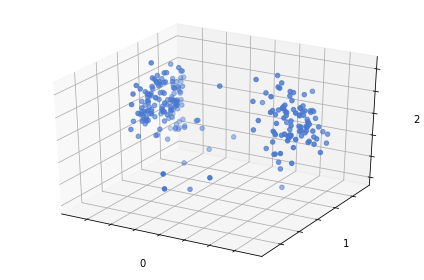

In [13]:
refer = OrdinationResults.read(refer_fp)
refer

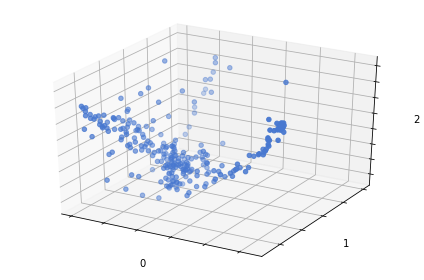

In [14]:
other = OrdinationResults.read(other_fp)
other

In [15]:
dims = len(refer.proportion_explained)
dims

10

Read metadata

In [16]:
meta = pd.read_csv(meta_fp, sep='\t', index_col=0)
meta = meta.loc[refer.samples.index]
meta.head()

,collection_year,Description,host_or_room,host_type,host_type2,house_number,sample_site,description,sample_site_general,socioeconomic_level,...,Shannon_16S,chao_16S,Shannon_18S,chao_18S,Shannon_18SnoAPF,chao_18SnoAPF,Shannon_ITS,chao_ITS,Shannon_MS,Observed_richness_MS
Che.418.kitc,2012,Peru2012,kitchen,house,wall,10.0,wall,wall,wall,NaN,...,2.736637,34.142857,NaN,NaN,NaN,NaN,NaN,NaN,4.752193,102.0
Pue.476.livi,2012,Peru2012,living,house,floor,11.0,floor,floor,floor,NaN,...,7.897638,1453.442623,NaN,NaN,NaN,NaN,6.873681,284.0,4.761067,114.0
Iqu.993.bedr,2012,Peru2012,bedroom,house,wall,25.0,wall,wall,wall,NaN,...,6.460763,133.076923,NaN,NaN,NaN,NaN,NaN,NaN,4.859672,121.0
Pue.682.bath,2012,Peru2012,bathroom,house,floor,16.0,floor,floor,floor,NaN,...,5.036059,295.681818,NaN,NaN,NaN,NaN,NaN,NaN,4.956010,110.0
Iqu.996.livi,2012,Peru2012,living,house,floor,25.0,floor,floor,floor,NaN,...,7.754165,881.158730,4.130021,102.352941,1.786952,29.0,5.049352,54.0,5.700441,127.0


Villages

In [17]:
meta['village_socio2'].unique()

array(['Checherta', 'Puerto Almendras', 'Iquitos', 'Manaus middle',
       'Manaus low'], dtype=object)

In [18]:
vdict = meta['village_socio2'].to_dict()

In [19]:
order = ['Checherta', 'Puerto Almendras', 'Iquitos', 'Manaus low',
         'Manaus middle']

In [20]:
colors = [hex2color(x) for x in [
    '#ff0000', '#008000', '#0000ff', '#ffff00', '#f27304']]

In [21]:
palette = dict(zip(order, colors))

### Scaling

In [22]:
factor = np.max(np.abs(refer.samples.values)) / np.max(np.abs(other.samples.values))
factor

2.790948289946274

In [23]:
other.samples *= factor

### Plot Procustes

In [24]:
dfr = refer.samples.copy()
dfr['village'] = dfr.index.to_series().map(vdict)

In [25]:
dfo = other.samples.copy()
dfo['village'] = dfo.index.to_series().map(vdict)

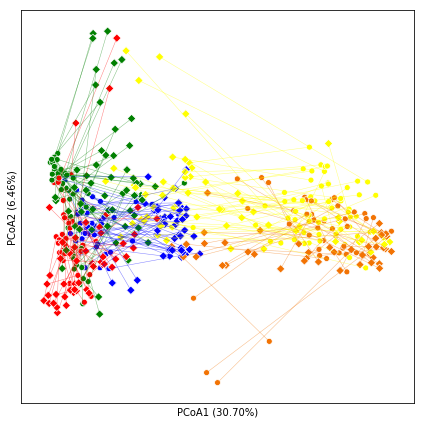

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=0, y=1, hue='village', data=dfr, marker='o',
                ax=ax, palette=palette, legend=False)
sns.scatterplot(x=0, y=1, hue='village', data=dfo, marker='D',
                ax=ax, palette=palette, legend=False)
ax.set_xlabel('PCoA1 (%.2f%%)' % (refer.proportion_explained[0] * 100))
ax.set_ylabel('PCoA2 (%.2f%%)' % (refer.proportion_explained[1] * 100))
ax.set_xticks([])
ax.set_yticks([])
for r, o in zip(dfr.itertuples(), dfo.itertuples()):
    ax.plot([r[1], o[1]], [r[2], o[2]], color=palette[vdict[r[0]]],
            alpha=0.5, linewidth=0.5)
fig.tight_layout()
fig.savefig('procrustes.pdf', bbox_inches='tight')

### Weighting

(Optional) weight coordinates by loadings

In [27]:
if weight:
    refer.samples *= refer.proportion_explained
    other.samples *= other.proportion_explained

### Paired distances

In [28]:
dists = []
for r, o in zip(refer.samples.itertuples(),
                other.samples.itertuples()):
    dists.append([vdict[r[0]], calc_dist(r, o, dims=dims)])

In [29]:
dfp = pd.DataFrame(dists, columns=['village', 'dist'])
dfp.head()

,village,dist
0,Checherta,0.003572
1,Puerto Almendras,0.004773
2,Iquitos,0.011890
3,Puerto Almendras,0.001590
4,Iquitos,0.005635


Plots

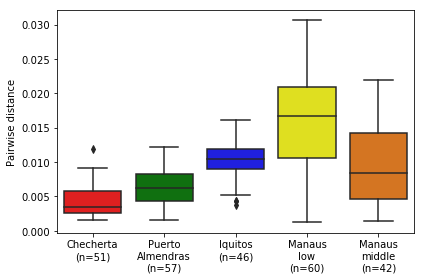

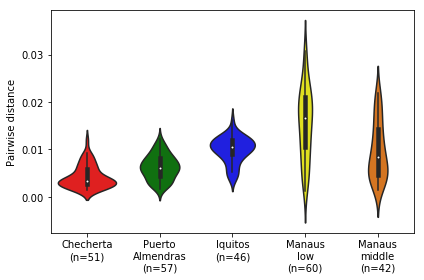

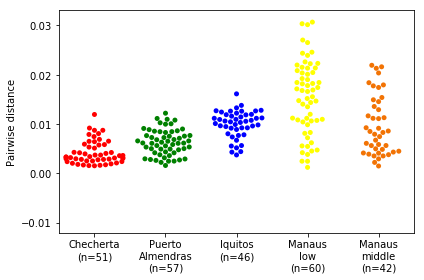

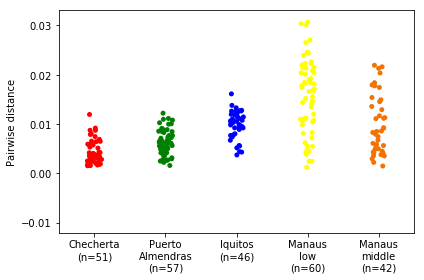

In [30]:
for key in ('box', 'violin', 'swarm', 'strip'):
    fig, ax = plt.subplots()
    getattr(sns, '%splot' % key)(
        x='village', y='dist', data=dfp, order=order, palette=colors, ax=ax)
    ax.set_ylabel('Pairwise distance')
    ax.set_xlabel('')
    ax.set_xticklabels(get_labels(dfp))
    fig.tight_layout()
    fig.savefig('pair.%s.pdf' % key, bbox_inches='tight')

In [31]:
d_dict = dfp.groupby('village')['dist'].apply(list).to_dict()
d_list = [d_dict[x] for x in order]

_K-W_ test

In [32]:
res = kruskal(*d_list)
res

KruskalResult(statistic=105.19505517949017, pvalue=7.6971289529822535e-22)

In [33]:
with open('pair.kw.txt', 'w') as f:
    f.write(str(res))

_U_-test

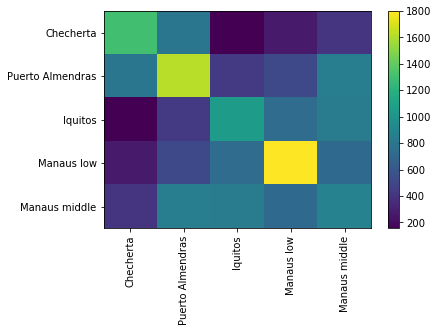

In [34]:
dmus = DissimilarityMatrix.from_iterable(
    d_list, lambda a, b:mannwhitneyu(a, b).statistic, keys=order)
dmus

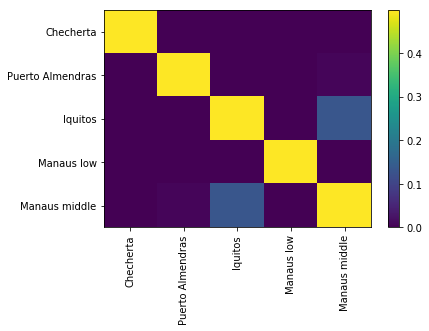

In [35]:
dmup = DissimilarityMatrix.from_iterable(
    d_list, lambda a, b: mannwhitneyu(a, b).pvalue, keys=order)
dmup

In [36]:
dmus.to_data_frame().to_csv('pair.u_stat.tsv', sep='\t')
dmup.to_data_frame().to_csv('pair.u_pval.tsv', sep='\t')

### All-vs-all distance matrix

In [37]:
dfr = refer.samples.copy()
dfr['village'] = dfr.index.to_series().map(vdict)
dfr.index += '.r'

In [38]:
dfo = other.samples.copy()
dfo['village'] = dfo.index.to_series().map(vdict)
dfo.index += '.o'

In [39]:
dfa = pd.concat([dfr, dfo])
dfa.head()

,0,1,2,3,4,5,6,7,8,9,village
Che.418.kitc.r,-0.014020,0.000568,-0.000365,-0.000253,0.000074,0.000009,0.000086,-0.000083,-0.000074,-0.000009,Checherta
Pue.476.livi.r,-0.010633,0.000269,-0.001282,0.000936,-0.000232,0.000716,-0.000378,0.000282,0.000039,0.000052,Puerto Almendras
Iqu.993.bedr.r,-0.012214,0.000230,-0.000848,-0.000357,0.000183,-0.000004,0.000126,-0.000090,-0.000129,-0.000097,Iquitos
Pue.682.bath.r,-0.012768,0.000752,0.000169,0.000069,-0.000024,-0.000232,0.000092,-0.000095,-0.000016,0.000102,Puerto Almendras
Iqu.996.livi.r,-0.004709,0.000527,-0.001198,0.000474,0.000044,-0.000233,-0.000417,0.000422,-0.000249,0.000032,Iquitos


In [40]:
dfa.shape[0]

512

In [41]:
def calc_dist_(a, b):
    return calc_dist(a, b, dims=dims)

In [42]:
dm = DistanceMatrix.from_iterable(
    dfa.itertuples(), calc_dist_, keys=dfa.index, validate=False)
dm.shape

(512, 512)

In [43]:
dists = []
for village in order:
    for dist in dm.filter(dfa.query(
        'village == "%s"' % village).index).condensed_form():
        dists.append([village, dist])
len(dists)

26404

In [44]:
df_ = pd.DataFrame(dists)
df_.columns = ['village', 'dist']
df_.head()

,village,dist
0,Checherta,0.001455
1,Checherta,0.001765
2,Checherta,0.003871
3,Checherta,0.001783
4,Checherta,0.003318


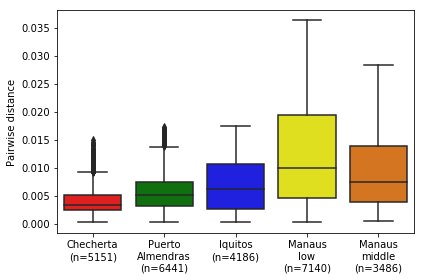

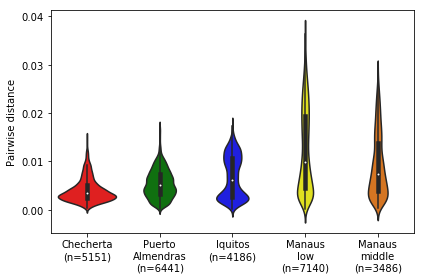

In [45]:
for key in ('box', 'violin'):
    fig, ax = plt.subplots()
    getattr(sns, '%splot' % key)(
        x='village', y='dist', data=df_, order=order, palette=colors, ax=ax)
    ax.set_ylabel('Pairwise distance')
    ax.set_xlabel('')
    ax.set_xticklabels(get_labels(df_))
    fig.tight_layout()
    fig.savefig('all.%s.pdf' % key, bbox_inches='tight')

### Manual plotting

In [46]:
def sig_label(text, i1, i2, x, y, order, df):
    delta = (df[y].max() - df[y].min()) / 20
    arr1 = df.query('%s == "%s"' % (x, order[i1]))[y].values
    arr2 = df.query('%s == "%s"' % (x, order[i2]))[y].values
    xx = np.abs(i1 + i2) / 2
    yy = np.max([np.max(arr1), np.max(arr2), np.median(arr1) + 1.5 * iqr(arr1),
                 np.median(arr2) + 1.5 * iqr(arr2)])
    ax.plot([i1, i2], [yy + delta * 1.5, yy + delta * 1.5], color='black')
    ax.plot([i1, i1], [yy + delta, yy + delta * 1.5], color='black')
    ax.plot([i2, i2], [yy + delta, yy + delta * 1.5], color='black')
    ax.text(xx, yy + delta * 2, text, ha='center', va='bottom')

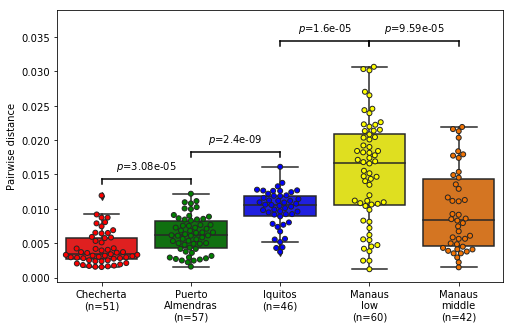

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='village', y='dist', data=dfp, order=order, palette=colors, ax=ax)
sns.swarmplot(x='village', y='dist', data=dfp, order=order, palette=colors, ax=ax,
             color='.25', linewidth=1)
ax.set_ylabel('Pairwise distance')
ax.set_xlabel('')
ax.set_ylim(top=ax.get_ylim()[1] * 1.2)
for i in range(len(order) - 1):
    sig_label('$\it{p}$=%.3g' % dmup[order[i], order[i + 1]],
              i, i + 1, 'village', 'dist', order, dfp)
ax.set_xticklabels(get_labels(dfp));

In [48]:
fig.tight_layout()
fig.savefig('pair.pdf', bbox_inches='tight')